In [57]:

import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

# Dataset

It is a many-to-many task.

In [58]:
narma_df = pd.read_csv('NARMA10.csv', header=None).transpose()
narma_df.columns = ['input', 'target']


narma_df.head(15)

,input,target
0,0.083964,0.00000
1,0.489340,0.00000
2,0.356350,0.00000
3,0.250240,0.00000
4,0.235540,0.00000
5,0.029809,0.00000
6,0.340990,0.00000
7,0.021216,0.00000
8,0.035723,0.00000
9,0.260820,0.00000


In [59]:
narma_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   input   10000 non-null  float64
 1   target  10000 non-null  float64
dtypes: float64(2)
memory usage: 234.4 KB


Show first 10 elems of the series

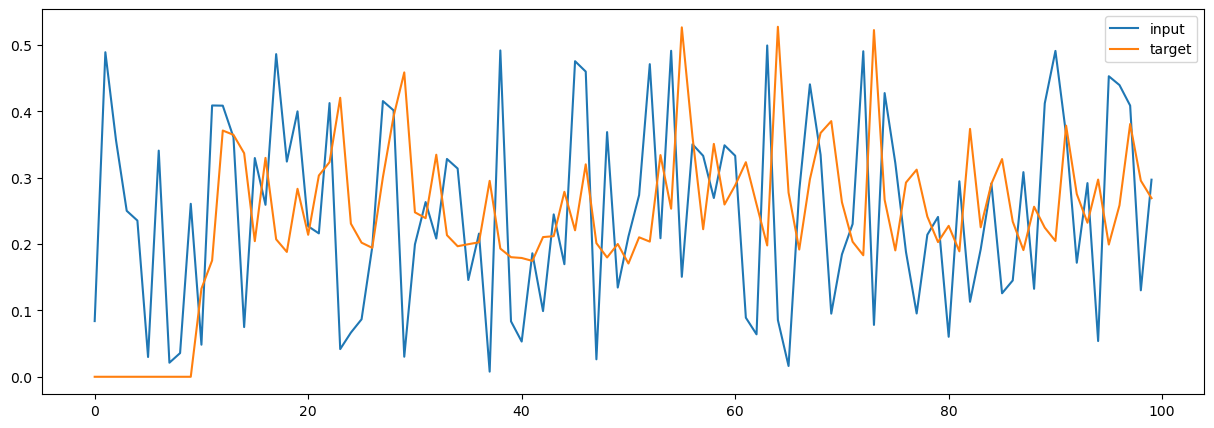

In [60]:
plt.plot(narma_df['input'][:100], label='input')
plt.plot(narma_df['target'][:100], label='target')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()

## Split Tr - Val - Test

In [61]:
tr_df = narma_df.iloc[:4000]
val_df = narma_df.iloc[4000:5000]
test_df = narma_df.iloc[5000:]

## Prepare datsets

In [62]:
tr_input = tr_df.input.values
tr_target = tr_df.target.values

val_input = val_df.input.values
val_target = val_df.target.values

test_input = test_df.input.values
test_target = test_df.target.values

devel_input = np.concatenate([tr_input, val_input])
devel_target = np.concatenate([tr_target, val_target])

print(tr_input.shape, tr_target.shape)

(4000,) (4000,)


# Echo State Network

In [63]:
class ESN():
    def __init__(self, input_size, output_size, num_hidden=128, omega_x=1.0, omega_b=1.0, rho=0.5, washout=50, reg_lambda=0.001) -> None:
        self.input_size = input_size
        self.output_size = output_size

        self.num_hidden = num_hidden
        self.omega_x = omega_x
        self.omega_b = omega_b
        self.rho = rho
        self.washout = washout
        self.reg_lambda = reg_lambda

        self.init_weights()


    def init_hidden_state(self, seq_len):
        # Hidden state initialized to 0
        self.hidden_state = np.zeros((self.num_hidden, 1))
        # Initialize hidden states history
        self.hidden_states_history = np.zeros((seq_len, self.num_hidden))


    def init_weights(self): 
        # Init input weights
        self.input_weights = np.random.uniform(-self.omega_x, self.omega_x, (self.num_hidden, self.input_size))
        # Input bias
        input_bias = np.random.uniform(-self.omega_b, self.omega_b, (self.num_hidden, 1))
        # Concat input bias to input weights
        self.input_weights = np.concatenate([self.input_weights, input_bias], axis=1)

        # Init readout weights
        self.output_weights = np.random.uniform(-1, 1, (self.output_size, self.num_hidden+1)) # +1 because bias is included in hidden state

        # Init hidden weights
        self.hidden_weights = np.random.uniform(-1, 1, (self.num_hidden, self.num_hidden))
        # Rescale to desired spectrla radius rho
        self.hidden_weights = self.hidden_weights * (self.rho / np.max(np.abs(np.linalg.eigvals(self.hidden_weights))))

    def update_reservoir(self, x):
        # Concat 1 to x for bias multiplication
        x = np.concatenate([x, np.ones((1, 1))])
        self.hidden_state = np.tanh(self.input_weights @ x + self.hidden_weights @ self.hidden_state)
        return self.hidden_state
    
    def train(self, input_seq, target_seq):
        seq_len = input_seq.shape[0]
        self.init_hidden_state(seq_len)
        # Update reservoir
        for i in range(seq_len):
            curr_hidden_state = self.update_reservoir(input_seq[i].reshape(-1, 1))
            self.hidden_states_history[i] = curr_hidden_state.reshape(-1)

        # Discard iniial transient
        H = self.hidden_states_history[self.washout:]
        # Add 1 column for hidden states bias
        H = np.concatenate([H, np.ones((H.shape[0], 1))], axis=1)

        # Calculate readout weights with ridge regression with regularization parameter lambda
        self.output_weights = np.linalg.inv(H.T @ H + self.reg_lambda * np.eye(self.num_hidden+1)) @ H.T @ target_seq[self.washout:]

    def predict(self, input_seq):
        seq_len = input_seq.shape[0]
        self.init_hidden_state(seq_len)
        # Update reservoir
        for i in range(seq_len):
            curr_hidden_state = self.update_reservoir(input_seq[i].reshape(-1, 1))
            self.hidden_states_history[i] = curr_hidden_state.reshape(-1)

        # Discard iniial transient
        H = self.hidden_states_history[self.washout:]
        # Add 1 column for hidden states bias
        H = np.concatenate([H, np.ones((H.shape[0], 1))], axis=1)

        # Predict through readout weights
        return H @ self.output_weights

In [64]:
# Function that initializes and train an ESN with the same hyperparameters multiple times.
# Returns the average MSE on the validation set.

def train_multiple(input_seq_tr, target_seq_tr, input_seq_val, target_seq_val, num_hidden, omega_x=1.0, omega_b=1.0, rho=0.5, washout=50, reg_lambda=0.001, num_trials=5):
    # Reshape to 2d if sequence has only 1 dimension
    if len(input_seq_tr.shape) == 1:
        input_seq_tr = input_seq_tr.reshape(-1, 1)
    if len(target_seq_tr.shape) == 1:
        target_seq_tr = target_seq_tr.reshape(-1, 1)
    if len(input_seq_val.shape) == 1:
        input_seq_val = input_seq_val.reshape(-1, 1)
    if len(target_seq_val.shape) == 1:
        target_seq_val = target_seq_val.reshape(-1, 1)

    input_size = input_seq_tr.shape[1]
    target_size = target_seq_tr.shape[1]

    # Exec multiple trials and average MSE on validation
    val_mse_list = []
    for i in tqdm(range(num_trials)):
        esn = ESN(input_size, target_size, num_hidden=num_hidden, omega_x=omega_x, omega_b=omega_b, rho=rho, washout=washout, reg_lambda=reg_lambda)  

        esn.train(input_seq_tr, target_seq_tr)

        pred_val = esn.predict(input_seq_val)
        val_mse_list.append(np.mean((pred_val - target_seq_val[washout:])**2))

    avg_val_mse = np.mean(val_mse_list)

    print('Average MSE:', avg_val_mse)

    print(val_mse_list)
    return avg_val_mse

In [53]:
val_mse = train_multiple(tr_input, tr_target, val_input, val_target, num_hidden=128)


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

Average MSE: 0.004468883343585155
[0.004468174874294844, 0.004472831780118254, 0.004462957519662185, 0.004466592880253039, 0.004473859663597454]


In [54]:
print('Val MSE:', val_mse)

Val MSE: 0.004468883343585155


Grid search params

In [65]:
num_hidden_list = [128, 256, 512]
washout_list = [10, 50] 
reg_lambda_list = [0, 0.0001, 0.001]
omega_x_list = [0.5, 1]
omega_b_list = [0.1, 0.5, 1]
rho_list = [0.1, 0.5, 0.99]

Grid search over the hyperparams. 

Once a better model on val loss is found, it is set as the current best model.

In [66]:
best_val_loss = math.inf

for num_hidden in num_hidden_list:
    for washout in washout_list:
        for reg_lambda in reg_lambda_list:
            for omega_x in omega_x_list:
                for omega_b in omega_b_list:
                    for rho in rho_list:

                        print('Training with num_hidden: {}, washout: {}, reg_lambda: {} omega_x: {}, omega_b: {}, rho: {}'
                              .format(num_hidden, washout, reg_lambda, omega_x, omega_b, rho))
                        
                        val_loss = train_multiple(tr_input, tr_target, val_input, val_target, num_hidden=num_hidden, omega_x=omega_x,
                                                  omega_b=omega_b, rho=rho, washout=washout, reg_lambda=reg_lambda)

                        # Save the current model if its best validation loss is better than the best validation loss so far
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            best_num_hidden = num_hidden
                            best_washout = washout
                            best_reg_lambda = reg_lambda
                            best_omega_x = omega_x
                            best_omega_b = omega_b
                            best_rho = rho

Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Average MSE: 78.60675835240836
[20.23721703512038, 9.054008721865081, 75.60285385718271, 287.98242876891214, 0.157283378961523]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Average MSE: 0.0009025916655018955
[0.00088042496167613, 0.0009363055692460215, 0.0009183806549551565, 0.0008521962424377055, 0.0009256508991944634]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Average MSE: 0.0005462132092033076
[0.0005933040809853355, 0.0004775520617255779, 0.0003327974451079142, 0.0006930361423312199, 0.0006343763158664903]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Average MSE: 24.071299712280982
[3.4675334294566857, 8.054312117447669, 4.830186619181047, 37.60395211200916, 66.40051428331036]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Average MSE: 0.0007701348508611654
[0.000834221911435039, 0.0008012364176059654, 0.00075330240130841, 0.0007312080227073979, 0.000730705501249015]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


Average MSE: 0.00033508744687759615
[0.00022406966205898207, 0.0002609005299316167, 0.0003503325316241484, 0.00042838433204511647, 0.0004117501787281169]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Average MSE: 270.2270453383706
[62.47280461119032, 1035.2606381109763, 75.92595828322828, 4.470381525884319, 173.00544416057397]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Average MSE: 0.0011829577236777515
[0.0011051835663127556, 0.0012604913950508088, 0.0010017641495415227, 0.0013670391862768297, 0.0011803103212068412]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Average MSE: 0.0004395286028858734
[0.0004106149495640137, 0.0006549250331020146, 0.0003991187693592334, 0.00032952019380545994, 0.00040346406859864524]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Average MSE: 214.16984996071264
[1.0150111215576836, 1.5052239857217473, 1065.9279790948249, 0.29779739740473943, 2.1032382040540805]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Average MSE: 0.0012569051587628954
[0.0012015786873485381, 0.0012439327175302873, 0.0013268362735081105, 0.0011515874145595635, 0.0013605907008679776]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Average MSE: 0.0006892188614499117
[0.0006835485310444498, 0.0006453796861759962, 0.0006874705831313697, 0.0006873573917077098, 0.0007423381151900333]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Average MSE: 197.27344887314663
[932.7955366348083, 0.7188253918139678, 46.198418561582095, 2.01533442154102, 4.6391293559877536]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Average MSE: 0.0015327475469920004
[0.0016956555637955696, 0.0014443926840358465, 0.0015323094560813475, 0.0013826301940516583, 0.0016087498369955803]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Average MSE: 0.0005793169901596849
[0.0003885338360052344, 0.0007878038235024679, 0.0004538835160824125, 0.000552236406535533, 0.0007141273686727769]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Average MSE: 8.04167812234745
[18.226739996668805, 19.15053924189162, 2.348468091821162, 0.3474187388517283, 0.13522454250393273]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Average MSE: 0.002744520838938656
[0.002589277872225364, 0.003103785885244412, 0.002318160428067196, 0.0026295680725427636, 0.003081811936613543]
Training with num_hidden: 128, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Average MSE: 0.0005018342253749811
[0.0006034786461384051, 0.0006187984055249126, 0.0004703173623462912, 0.00041813054501475035, 0.0003984461678505466]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Average MSE: 0.004448907800938667
[0.004452232535159779, 0.004447184946380449, 0.004448220261207634, 0.004447816148867417, 0.00444908511307806]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Average MSE: 0.0018843925156701712
[0.002002492543731373, 0.0014032379276978804, 0.0024541224931820846, 0.0017481454459618677, 0.0018139641677776515]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Average MSE: 0.0006614109444160539
[0.000590832107501582, 0.0005419699910527762, 0.0009111201058832747, 0.0006724059434430465, 0.0005907265741995905]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Average MSE: 0.0044617128106187575
[0.004461105732134182, 0.004460902872005237, 0.004462362586122951, 0.004461336835438457, 0.004462856027392959]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Average MSE: 0.0033406448277064167
[0.0032980030384392018, 0.003057830204136034, 0.00370222728505508, 0.0039472004289352975, 0.002697963181966469]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Average MSE: 0.00037312335417201675
[0.0004166144496991077, 0.00023947687877346567, 0.0002664691982300575, 0.0005447964092391599, 0.0003982598349182928]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Average MSE: 0.0044620985078429
[0.004460800110927266, 0.004460950464788592, 0.004464079837357864, 0.004463340480308609, 0.004461321645832169]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Average MSE: 0.004449193048230679
[0.004436563966652326, 0.0044091565430020106, 0.004481556345100111, 0.004453408676270446, 0.004465279710128502]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Average MSE: 0.0007294787061946337
[0.0007148053972227445, 0.0008921900952602016, 0.0005287225882047057, 0.0006370706868023723, 0.0008746047634831441]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


Average MSE: 0.0044686991474694425
[0.004471734026026868, 0.004466995061157145, 0.004467736497316563, 0.0044681489560253, 0.004468881196821338]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


Average MSE: 0.0022200629091641316
[0.0015557617124232976, 0.0026410697776073945, 0.0024380097199618875, 0.002253289515653043, 0.0022121838201750355]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Average MSE: 0.0006899705090366937
[0.0005730817943547465, 0.0006701270119151728, 0.0007567278218767655, 0.0006532349140529605, 0.0007966810029838232]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Average MSE: 0.004473511945693254
[0.004475815575786301, 0.004474032867822562, 0.004471932964379363, 0.0044731308203430865, 0.004472647500134956]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Average MSE: 0.003466615402480007
[0.003493348499233734, 0.0035601173265268813, 0.0030478628589049326, 0.003230343050457711, 0.004001405277276775]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Average MSE: 0.0005700327191074273
[0.0006084362631218428, 0.0004683578440954257, 0.0006214901006789333, 0.0006453148721228742, 0.0005065645155180604]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


Average MSE: 0.00447337470201601
[0.004473367527497121, 0.004470577467933384, 0.004473542175610235, 0.004475205979359729, 0.0044741803596795825]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Average MSE: 0.004389097668361724
[0.00444686927022797, 0.004415672940474111, 0.004398412892746663, 0.0043825671006601195, 0.004301966137699759]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Average MSE: 0.0006159986193668223
[0.0006152206325233783, 0.0007119937721458587, 0.0005641756563594395, 0.0005403116202902423, 0.0006482914155151928]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Average MSE: 0.0044464068499109
[0.004446930394653925, 0.004445208112846381, 0.004445813828819901, 0.004444856455723124, 0.004449225457511168]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Average MSE: 0.0036273038813169783
[0.0037123007067452413, 0.0036769575230614694, 0.0034689364213527814, 0.003951880707535904, 0.0033264440478894953]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Average MSE: 0.0005980234349492957
[0.00039027757525613577, 0.0005677459703873158, 0.0007435867427924674, 0.0004846144976697841, 0.0008038923886407754]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Average MSE: 0.0044533624178524165
[0.004452603318356557, 0.00445239642928663, 0.004453245885374726, 0.004454714048570836, 0.004453852407673332]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Average MSE: 0.004340343970294121
[0.004238828752994616, 0.0044542928436265405, 0.004276620241391525, 0.004330549304260824, 0.004401428709197098]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Average MSE: 0.0005385090652199421
[0.0004349269844292518, 0.0004698968393162408, 0.0007257304965151954, 0.00048334175464965676, 0.0005786492511893656]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Average MSE: 0.004459442788370979
[0.0044549495162378265, 0.004458013288225507, 0.004460321731328128, 0.004460998062463292, 0.004462931343600144]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Average MSE: 0.004477415862288003
[0.004482479061139886, 0.004475631303036089, 0.0044715897695905135, 0.004472298745121631, 0.004485080432551894]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Average MSE: 0.0010908362064119142
[0.0008990303262090741, 0.001136334850945802, 0.0015010279715612417, 0.0011224352451925125, 0.0007953526381509404]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Average MSE: 0.00445688846814532
[0.004456510502039503, 0.004457600123624736, 0.004456798931434203, 0.00445858115146228, 0.004454951632165879]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Average MSE: 0.0031764053356904353
[0.002715746230663278, 0.003323032424992469, 0.002982857811512433, 0.0033345363318464925, 0.003525853879437505]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Average MSE: 0.0006919532654759311
[0.0006207352908312864, 0.0006822078289798284, 0.0007301668949266709, 0.0008374199937961609, 0.000589236318845709]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Average MSE: 0.004462785877995699
[0.004461821520046504, 0.0044629130858535185, 0.004464281459979117, 0.00446288628420327, 0.004462027039896084]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Average MSE: 0.0041564312004357725
[0.004334794691764089, 0.0039106933378175775, 0.004175684108133712, 0.004160789281288228, 0.004200194583175258]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Average MSE: 0.0005720571487204843
[0.0006186555998113273, 0.000565105756932164, 0.0005238635303962472, 0.0006166972354433464, 0.0005359636210193368]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Average MSE: 0.004466533018473434
[0.004465295421002819, 0.004466295234586804, 0.00446681783566457, 0.004466990905793562, 0.004467265695319412]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Average MSE: 0.004470998134216394
[0.004483823252037986, 0.004473818655040755, 0.004484852988556504, 0.004437839473799656, 0.004474656301647074]
Training with num_hidden: 128, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Average MSE: 0.00085081989474026
[0.0010158680256445152, 0.0008250997341978341, 0.0005992634236851058, 0.001089271795612296, 0.0007245964945615489]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Average MSE: 2820.026089790518
[0.4262704166314785, 14053.612941009053, 23.197831989738567, 14.336084897749492, 8.557320639415765]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


Average MSE: 0.0009192126290539879
[0.0009175645863058449, 0.0009504928673887564, 0.0007572204094599121, 0.0009734218229821797, 0.0009973634591332469]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Average MSE: 0.0005484672231441028
[0.0006620610661521515, 0.0004492130854650954, 0.0006043042996553205, 0.0005969670443194487, 0.0004297906201284977]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Average MSE: 55.418936048520706
[128.2747149547243, 1.377512401905173, 95.53159612525769, 3.62475845190259, 48.286098308813834]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Average MSE: 0.0008078527922121337
[0.0007618153467981092, 0.000894725878758502, 0.0006823067155424505, 0.0008145275607242885, 0.0008858884592373186]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Average MSE: 0.00028135428260635687
[0.0003311647795581864, 0.0002455146753678653, 0.00025803667664529547, 0.00027460237263369835, 0.0002974529088267388]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


Average MSE: 150.69815121298538
[1.8056846331139222, 153.97233403109078, 7.081395845708939, 74.13810094337941, 516.493240611634]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Average MSE: 0.0013730595976035244
[0.0013516742567466003, 0.0012037946578150266, 0.0011493729071679754, 0.0014002378400155154, 0.0017602183262725047]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


Average MSE: 0.00029705178682891593
[0.00037328370011024655, 0.0002738108066341967, 0.0004775957686468864, 0.00018621035522454408, 0.00017435830352870567]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Average MSE: 66.5947571502549
[0.46748842855462597, 325.9927778140835, 2.69135528142546, 2.3951995586070454, 1.4269646686039064]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Average MSE: 0.0012019561251931737
[0.00118273086913027, 0.0012779823350284214, 0.0012149268720415387, 0.001109766720227817, 0.0012243738295378206]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Average MSE: 0.0006808078351887559
[0.0007147094291519629, 0.0008672593617557763, 0.0007158404630844361, 0.0004185910880746929, 0.0006876388338769115]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Average MSE: 214.93522599446555
[5.220222085637343, 9.866419090911268, 1056.6302686301287, 2.802773684377205, 0.15644648127310018]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


Average MSE: 0.0014604320008992655
[0.0010843954745223079, 0.0018685341650804739, 0.001440374322834159, 0.0013007496142314725, 0.0016081064278279141]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Average MSE: 0.0005371368239547052
[0.00043756235509312435, 0.0005396441781609221, 0.00044637988953007157, 0.0006443187490746837, 0.0006177789479147242]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Average MSE: 12.452210492703015
[0.2060090057446138, 3.5953936704420517, 13.404737087660108, 0.42912961722377424, 44.62578308244453]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Average MSE: 0.002794323620308635
[0.0028305192622772282, 0.0034214243124654313, 0.0022006393308861266, 0.002467999953237601, 0.0030510352426767876]
Training with num_hidden: 128, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Average MSE: 0.0005235132453800616
[0.0004469654440288533, 0.0006320971442302344, 0.0004933429304030299, 0.000521108871489827, 0.0005240518367483635]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Average MSE: 0.0044446625338472965
[0.004445796559708867, 0.0044434965961683455, 0.004444306050508369, 0.0044457825356880405, 0.004443930927162863]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Average MSE: 0.002646609747291503
[0.003907932146386053, 0.002069108794473782, 0.00204693681581765, 0.003077555792156793, 0.002131515187623237]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Average MSE: 0.0006412973273504494
[0.0007309042247026543, 0.0003690666680410431, 0.0005395237263628943, 0.0008954166530182474, 0.0006715753646274076]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Average MSE: 0.004455643579732308
[0.004455797150035112, 0.0044547898026635925, 0.004456384099666582, 0.0044563070837133475, 0.004454939762582901]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Average MSE: 0.0037742498353391164
[0.004092289312552625, 0.003612434227801482, 0.0042567196740543375, 0.0037292974185021963, 0.0031805085437849392]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Average MSE: 0.00042775756067815214
[0.00033493263237181764, 0.00041914058703358854, 0.0004249708560601201, 0.0003800342593731611, 0.0005797094685520734]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Average MSE: 0.004457298121636744
[0.0044568790703629875, 0.004457538245448758, 0.004457933320396638, 0.0044581876661587685, 0.004455952305816568]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Average MSE: 0.004448347811446425
[0.004443523403597438, 0.004473721299614757, 0.004409995589276, 0.004457415492591009, 0.004457083272152922]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Average MSE: 0.000548761552077463
[0.0008957761361859344, 0.0005968343505539028, 0.00043465909300557606, 0.00030324527799753347, 0.0005132929026443679]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Average MSE: 0.004462696582714027
[0.0044610783158875915, 0.00446259298807742, 0.0044610306808222965, 0.004464688653956236, 0.004464092274826588]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Average MSE: 0.0021402021532200294
[0.002777279637420476, 0.0025051362855242026, 0.0016601109141959162, 0.002114540059620267, 0.0016439438693392852]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Average MSE: 0.0006480776545929025
[0.0004400907166966163, 0.0007860254713411681, 0.0006696180514878341, 0.0006366270588222437, 0.0007080269746166502]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Average MSE: 0.004465207244819778
[0.004466380043166446, 0.004463658212210063, 0.004464126972701796, 0.00446785436437976, 0.004464016631640824]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Average MSE: 0.0034385199035132036
[0.002994094249550853, 0.004081034206350146, 0.0031606891145291734, 0.0037025111702762366, 0.003254270776859609]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Average MSE: 0.00046815407737835966
[0.0007293776390635699, 0.00047610245006997906, 0.0004272776056680661, 0.0004427223244980321, 0.00026529036759215133]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Average MSE: 0.004465580059596017
[0.00446752569041323, 0.004464018775522904, 0.004465275594254596, 0.004465564826807188, 0.0044655154109821665]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Average MSE: 0.004332465321213679
[0.004442094056512153, 0.004400906436717598, 0.004395595794542977, 0.004425542290367765, 0.0039981880279278985]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


Average MSE: 0.0005751028972076661
[0.00046589724743501557, 0.0005513852730766731, 0.0007815784247914528, 0.0006392382387703873, 0.0004374153019648019]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Average MSE: 0.004440554022777677
[0.00443896024937795, 0.0044414771997003, 0.004440414807516182, 0.004441855831988938, 0.004440062025305012]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Average MSE: 0.0038002313106305927
[0.003718040146963957, 0.0036132212823142204, 0.003895882419527782, 0.0037616712577613165, 0.004012341446585685]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Average MSE: 0.0006450593961813173
[0.0006387460347155362, 0.0005209298620357342, 0.0006670222868603817, 0.0006601025244337638, 0.0007384962728611706]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Average MSE: 0.0044472481915806454
[0.0044445229212566415, 0.0044464617012599785, 0.004445764564823038, 0.004447246963666536, 0.004452244806897038]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Average MSE: 0.004294689208936478
[0.004338729070719246, 0.004275567751781886, 0.00420476810961654, 0.004254214835001969, 0.00440016627756275]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Average MSE: 0.00041538532712605676
[0.00044624095058469243, 0.0003534705934088221, 0.000496200751472125, 0.0004202723596530451, 0.00036074198051159925]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Average MSE: 0.0044538635779984015
[0.004455731884486282, 0.0044541510655584865, 0.004450809707256649, 0.004453887161789529, 0.004454738070901059]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Average MSE: 0.004471679498118669
[0.004474407853743316, 0.004470434566177492, 0.00447013948130907, 0.004474559539033739, 0.004468856050329723]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Average MSE: 0.0010450077877774287
[0.0010323609605547132, 0.0007255713203128787, 0.0009680974556288093, 0.0011280026188134314, 0.0013710065835773112]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Average MSE: 0.00445252701834113
[0.004453916150531931, 0.004449815170665724, 0.004450902149497027, 0.004454260439409371, 0.004453741181601601]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Average MSE: 0.0032969609604623605
[0.003210841885393172, 0.0035877465119522334, 0.003173553041509331, 0.0032209207241024424, 0.0032917426393546255]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Average MSE: 0.0006531576340574916
[0.0006685954839265865, 0.0007537089804635973, 0.000585390393907053, 0.0005999659018041584, 0.0006581274101860626]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Average MSE: 0.004457148901292592
[0.004457256426856845, 0.004457286180889805, 0.004459036484727133, 0.004456003499192509, 0.004456161914796664]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Average MSE: 0.004263568298293845
[0.004202588531481106, 0.00419130080221586, 0.004131260633463064, 0.00439147129744524, 0.004401220226863957]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Average MSE: 0.00047560260959903894
[0.000448813931135674, 0.0003823504344047555, 0.00042924052867970034, 0.0007314262280758805, 0.0003861819256991843]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


Average MSE: 0.00446017233420542
[0.004463031499153449, 0.004460383676587601, 0.0044573972209885114, 0.004461727646089098, 0.004458321628208443]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Average MSE: 0.004470131048776771
[0.004468280657965623, 0.004469756627604299, 0.004470131857769547, 0.004469483195338161, 0.004473002905206228]
Training with num_hidden: 128, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Average MSE: 0.0007319991598047737
[0.0008086874697836424, 0.000763597436815755, 0.0006753900154980647, 0.000983784462124273, 0.00042853641480213327]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 658.6575166473493
[255.38423440212938, 64.55932644604894, 534.8838407080691, 2361.0300011973236, 77.4301804831759]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Average MSE: 0.0001510601541174741
[0.00018064199624346898, 0.0001307996801377564, 0.00013733852532951622, 0.00016713296820869045, 0.00013938760066793836]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 0.0003744687765719218
[0.00024425525502442673, 0.00036839896970575366, 0.0003441357022316383, 0.0005581572043167204, 0.0003573967515810698]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Average MSE: 9347.7675306885
[16.081173899611237, 27.094627556765722, 10.420454491977194, 956.008602476238, 45729.2327950179]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Average MSE: 0.00014905811648485543
[0.00012632933664746804, 0.0001922588007639963, 0.0001430642408444856, 0.00018637162889000199, 9.726657527832525e-05]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Average MSE: 9.675660220439355e-05
[9.66644120057607e-05, 0.00013936231547920886, 0.00010761247464598255, 7.601804196359153e-05, 6.412576692742409e-05]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Average MSE: 544.3185298944079
[1.491875836061478, 24.143851551458074, 1.8707462808648383, 2692.138142467238, 1.948033336416834]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Average MSE: 0.031099321078772436
[0.005301958025002929, 0.00020401448375726382, 0.07788986302450643, 0.013267981980521523, 0.05883278788007404]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Average MSE: 0.00010227931817854689
[5.000654438734953e-05, 0.0001795576813910195, 8.738668663583072e-05, 0.00014200068222751402, 5.244499625102072e-05]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Average MSE: 41.82971322063453
[38.48374733105322, 1.0452581891859896, 104.68086643223502, 46.955103173564204, 17.983590977134227]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Average MSE: 0.00042430561152023087
[0.000424262110860191, 0.0004855794297648386, 0.00044207863738069504, 0.00032583009662031444, 0.00044377778297511515]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 0.0003145501940434118
[0.0002932586792819825, 0.0002716659853901278, 0.0003678906085305594, 0.0003412597482504669, 0.00029867594876392233]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 1676.2702984595137
[101.1345182514753, 7517.373180388544, 4.1722227624192625, 745.8661395052201, 12.805431389909478]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Average MSE: 0.00048614162020152175
[0.000405285168824759, 0.0006024335359369809, 0.0006098145109894596, 0.0004877716167641025, 0.0003254032684923065]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Average MSE: 0.0001801565991675206
[0.00021059801655227172, 0.00020567126658197944, 0.00018516438077304038, 0.00013983129456685467, 0.0001595180373634569]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Average MSE: 1239.5542488069043
[147.37223236102662, 16.082760567979353, 13.327041833915633, 5990.1622697333905, 30.826939538209]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Average MSE: 0.000930946123364964
[0.000814398448730539, 0.0011464665076754148, 0.0009905048766275472, 0.0009858346893744496, 0.0007175260944168693]
Training with num_hidden: 256, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Average MSE: 0.0001162652946783273
[0.00012385945893996148, 0.0001198629376409978, 0.00010054520347304965, 0.0001079475751274082, 0.00012911129821021935]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Average MSE: 0.004453450014389537
[0.004455205380665819, 0.00445379746194991, 0.00445268798544122, 0.004452358208796131, 0.004453201035094602]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Average MSE: 0.0014934438737377708
[0.001384377728075818, 0.001308905165902931, 0.0019518085541769612, 0.0013792315615751294, 0.001442896358958015]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Average MSE: 0.0002981003419667757
[0.00041885675209252135, 0.0002180540626185702, 0.0002206541567005432, 0.00035373384408072655, 0.0002792028943415169]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Average MSE: 0.004463520377975087
[0.00446174894081962, 0.004462978492982799, 0.004462627396385416, 0.004464045993695347, 0.004466201065992255]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Average MSE: 0.0024598448990057918
[0.002055283301147162, 0.0026689163829311576, 0.0017053038681920686, 0.0028525129782555098, 0.0030172079645030625]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Average MSE: 9.759930415230809e-05
[8.057975016771313e-05, 8.689070651227962e-05, 0.00010862345810621085, 0.000109725119803748, 0.00010217748617158883]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Average MSE: 0.004464008473658387
[0.004463466580078908, 0.0044652877336780195, 0.004463722287672299, 0.004463130494282371, 0.004464435272580337]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Average MSE: 0.004394878398389089
[0.004386319030605495, 0.00434901551014777, 0.004441494908273018, 0.004375692758675432, 0.004421869784243727]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 0.0003221971201198538
[0.00035676984690042896, 0.00024242904302043623, 0.00029001506007588526, 0.0005432842344248777, 0.00017848741617764084]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 0.004473296990558918
[0.0044717547453092775, 0.004473383831858996, 0.0044729978988776835, 0.004473598321798083, 0.004474750154950549]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Average MSE: 0.0014198179221432687
[0.0013328975252979345, 0.00151575588950899, 0.0014863936973522009, 0.0013313298901947862, 0.0014327126083624323]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Average MSE: 0.00027449527561142104
[0.0003091031976597215, 0.00019335371437518642, 0.000292646502016842, 0.00033772339555236203, 0.00023964956845299324]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Average MSE: 0.004478265737612241
[0.004478040580419598, 0.00447683863419414, 0.004477503467222263, 0.004480011364336455, 0.0044789346418887465]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Average MSE: 0.0022280302922854833
[0.0025184324389149744, 0.002499054662206174, 0.0019347060892122236, 0.0021880126761446863, 0.001999945594949356]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 0.00014119938311690355
[0.00017364102845927317, 0.00012413966338372103, 0.0001381441251306547, 0.00010633553508517577, 0.00016373656352569303]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Average MSE: 0.0044776192110637025
[0.004475918583169265, 0.0044776394059078215, 0.00448039785083718, 0.004477681647363822, 0.004476458568040423]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Average MSE: 0.004206524482995801
[0.004265537667404866, 0.004413705781353524, 0.0038158315824023616, 0.004405390000214924, 0.0041321573836033305]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 0.00017935328151271086
[0.0002546626755918552, 0.00019627448846348523, 0.00010799573614163918, 0.00017326826403995735, 0.0001645652433266173]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Average MSE: 0.004444543647702302
[0.0044447811959227096, 0.0044453770500757755, 0.004444954259021182, 0.004443684732400197, 0.004443921001091646]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 0.0029394570807552978
[0.00316057490006075, 0.002976438619436202, 0.0025332568384811758, 0.0029668942286312882, 0.003060120817167071]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Average MSE: 0.00032221556164118266
[0.00033519574640647845, 0.00038156264968118364, 0.00034099144027803827, 0.00023300979828909428, 0.00032031817355111856]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Average MSE: 0.004454600390399744
[0.0044535837208142725, 0.004453706927473054, 0.004455300035400907, 0.004454546369547009, 0.004455864898763478]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 0.0039300871620328
[0.003962391358708367, 0.0038700118923789546, 0.003885807292770135, 0.004043897071387271, 0.003888328194919272]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Average MSE: 0.0001722743514017995
[0.00012804622008826322, 0.00020911838609194422, 0.0002537259889222555, 9.898632861267474e-05, 0.00017149483329385976]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 0.0044590086196446155
[0.004457765359169604, 0.004457575020415661, 0.004459094805103921, 0.004462219005682439, 0.004458388907851453]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Average MSE: 0.004469007275572654
[0.004470178568763328, 0.004479988873009672, 0.004476291293838757, 0.0044727687919823185, 0.004445808850269193]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 0.000572386914598504
[0.0005269284896000954, 0.0004674406027108447, 0.00028564961358377544, 0.000506058415154716, 0.0010758574519430881]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 0.004460498045375032
[0.0044614241583142596, 0.004459996937940421, 0.004459544595537307, 0.004461060978035883, 0.004460463557047286]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Average MSE: 0.0026008963004097566
[0.002817147244358561, 0.0027883386553864847, 0.0021711988103672304, 0.0027304381419183173, 0.0024973586500181885]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Average MSE: 0.0002818961673378505
[0.00022783484905979423, 0.0002686595863027014, 0.00031598383329808466, 0.00029430751645495774, 0.0003026950515737147]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Average MSE: 0.004465898182236393
[0.004466080977868522, 0.004465622868773447, 0.0044660401573645755, 0.004465943727687522, 0.004465803179487896]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Average MSE: 0.0036057467438792463
[0.004026499262458544, 0.0035788526559549913, 0.0033555699531461485, 0.003489361805945458, 0.0035784500418910912]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Average MSE: 0.00016182052804951163
[0.00015127734271516645, 0.00021744544443255172, 0.00012416526037107724, 0.00013859634537634775, 0.00017761824735241496]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Average MSE: 0.004466575083623211
[0.0044657839465219755, 0.004467286945754215, 0.004467198269821968, 0.004466241878963614, 0.004466364377054281]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Average MSE: 0.004453862928347313
[0.004420354504415993, 0.004466846694861038, 0.0044708583296533475, 0.004478439103242717, 0.004432816009563469]
Training with num_hidden: 256, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Average MSE: 0.0003106206828098614
[0.0002658772543727739, 0.0005303243553534187, 0.0001773421531165268, 0.00028948170148032155, 0.000290077949726266]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Average MSE: 6782.595047218017
[4148.640276051499, 20.74386444762581, 26324.852323594634, 149.33750531828628, 3269.4012666780395]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Average MSE: 0.0001266776930411078
[0.0001233633376913446, 9.726609440440556e-05, 0.0001275975349332348, 0.00019170963954341893, 9.345185863313513e-05]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Average MSE: 0.0003320502781028539
[0.00013434500875871745, 0.00021570727882784638, 0.00043728229053604834, 0.0005092882380103144, 0.0003636285743813429]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 24.76453529925028
[48.62338047921909, 64.87816053192765, 2.89405383728898, 7.36152453053148, 0.06555711728419462]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Average MSE: 0.00012892968337470541
[0.00015545670039610694, 0.0001587758390151715, 0.00013681827388439333, 9.09850440348292e-05, 0.00010261255954302601]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Average MSE: 5.7301038362741856e-05
[3.020813795959777e-05, 6.706027331767914e-05, 7.00103271184053e-05, 6.415926720965725e-05, 5.5067186208369816e-05]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Average MSE: 1060.6323597632197
[105.75753340961835, 31.26609924554918, 5127.195504785072, 38.34613107822261, 0.5965302976365305]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 0.012357080961413639
[0.017400032702699512, 0.012266006098564158, 0.026958081111645608, 0.0006158332289339604, 0.004545451665224967]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Average MSE: 2.507885309792694e-05
[1.6158222031576105e-05, 3.282717994601654e-05, 2.5398701669240702e-05, 3.0278871273905728e-05, 2.0731290568895624e-05]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Average MSE: 8510.072189120327
[23.59133575772066, 0.8468588168653364, 664.2351629707408, 41857.8273125814, 3.8602754749063464]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Average MSE: 0.00044957326772657294
[0.00046392655208919373, 0.0005345779411819525, 0.0003208694340174768, 0.0005201419145616825, 0.00040835049678255897]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Average MSE: 0.0002804942928034223
[0.0003594196459941476, 0.00032531939994666673, 0.0002496994128084822, 0.0002052453552437684, 0.00026278765002404653]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Average MSE: 382.190988192584
[11.571448981201288, 68.92321627053636, 33.10294799783618, 4.9202197283684574, 1792.4371079849775]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Average MSE: 0.00044704229196302643
[0.0005025462718223281, 0.0003334476022973517, 0.0003879053464194323, 0.0005818046593745228, 0.0004295075799014977]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Average MSE: 0.00011149309642227
[9.351512603347062e-05, 0.00010747202171650907, 0.00011195064498857669, 0.00013241305129116186, 0.00011211463808163171]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Average MSE: 251.99254918723855
[126.15175126722778, 309.27367732189873, 18.939616657493467, 658.9402710221015, 146.65742966747126]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Average MSE: 0.0010065188957134358
[0.00082148689716255, 0.0010780538957052875, 0.0010255358258845835, 0.0011361651229180312, 0.0009713527368967257]
Training with num_hidden: 256, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Average MSE: 0.00012670559288257015
[0.00016081776382719193, 7.062777725247421e-05, 0.00016171419610886155, 0.00010549042178642475, 0.00013487780543789825]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Average MSE: 0.004449567660689697
[0.004451299815110878, 0.004450054758400376, 0.004450111579587141, 0.0044489077096990385, 0.004447464440651053]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Average MSE: 0.0013907521667841825
[0.001409110660049787, 0.001456591787556633, 0.0012790944494895952, 0.001386373074678214, 0.0014225908621466824]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Average MSE: 0.00022932791568826806
[0.00020779805227026405, 0.00046396406520908236, 7.572262783432765e-05, 0.00018692751268990947, 0.00021222732043775687]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Average MSE: 0.004458151163073089
[0.004458013991181318, 0.004458333842374659, 0.004457801335616914, 0.0044592419088819, 0.004457364737310659]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Average MSE: 0.0028202594715421503
[0.002675014709786837, 0.0028290691708291924, 0.00246341091742566, 0.00329597009846191, 0.0028378324612071512]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 5.7847496842725995e-05
[5.77998005186729e-05, 5.8723334480484515e-05, 4.4391877422740484e-05, 6.75173464822961e-05, 6.080512530943601e-05]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Average MSE: 0.004458975996532904
[0.004459550298597371, 0.004459276710512847, 0.004459203886601224, 0.004458644934057088, 0.004458204152895995]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Average MSE: 0.004295562862747398
[0.004332366323815278, 0.004348797457774657, 0.004002215323840646, 0.00441823565408313, 0.0043761995542232765]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Average MSE: 0.00020647703353125174
[0.00012765747242046837, 0.00035600453977444697, 0.0001364231769715948, 0.0001685283050010658, 0.00024377167348868265]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Average MSE: 0.004466326238572302
[0.004466650844395003, 0.004466108214371692, 0.004465916142961601, 0.004466337443010729, 0.004466618548122482]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Average MSE: 0.0014764724221429603
[0.0017144676018001545, 0.0015317904101232835, 0.0012914755117587487, 0.0012434532065734392, 0.0016011753804591761]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Average MSE: 0.00025516053411301905
[0.0002551914681134589, 0.0002738810402397768, 0.00023762323401995005, 0.00024570615713643466, 0.00026340077105547474]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Average MSE: 0.0044690427732474005
[0.004468929329654346, 0.004470552950368267, 0.004469477659783267, 0.00446727010154783, 0.00446898382488329]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 0.0019963958557906447
[0.002267298247866479, 0.0018206930843558367, 0.0017134826852891023, 0.0018866408674701755, 0.002293864393971631]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Average MSE: 0.0001280756232251583
[0.00010884702893168411, 9.462607190100289e-05, 0.00012877636971133613, 0.0001406449070434007, 0.00016748373853836762]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Average MSE: 0.004467951148604917
[0.00446751856780406, 0.004469101099324196, 0.004466031603126113, 0.004467100351251138, 0.004470004121519078]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Average MSE: 0.004183014985744688
[0.00430684271643849, 0.004312296047600805, 0.0042016809118678436, 0.0038108959584729945, 0.004283359294343302]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Average MSE: 0.0001606254990744748
[0.00020055944430082316, 0.00020686816737787916, 0.00016749731319849127, 0.00010596138568595946, 0.00012224118480922094]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Average MSE: 0.0044401750796178125
[0.0044402341745465096, 0.004439727933410006, 0.004440425010560649, 0.004440808890405995, 0.0044396793891659046]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Average MSE: 0.0027160613212309503
[0.0028805590115656204, 0.0020090966893812267, 0.003227493638585468, 0.002531084899554079, 0.0029320723670683553]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Average MSE: 0.00029350100341175053
[0.0004358177684584199, 0.0002514108907138352, 0.00017983222064366065, 0.00018660559603358686, 0.0004138385412092501]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Average MSE: 0.004449554696387252
[0.004448903765292472, 0.004448636180081406, 0.004449116462790396, 0.004450136878383742, 0.004450980195388246]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Average MSE: 0.004107393262747958
[0.004254179928138666, 0.0042946497150464944, 0.004116931804366058, 0.0039009157892573505, 0.0039702890769312184]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Average MSE: 0.00014021381223962471
[9.874893707918985e-05, 0.00013332021653031953, 0.00017092613205404439, 0.00016062120033945063, 0.00013745257519511917]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Average MSE: 0.004452994229933104
[0.004452079258419921, 0.004451693216774875, 0.004453275273338138, 0.004453470949336999, 0.004454452451795587]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Average MSE: 0.004466407448874959
[0.004470274218362506, 0.004461800188395243, 0.00446324364618537, 0.004464641173819333, 0.004472078017612348]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Average MSE: 0.0005392495892463929
[0.0004396045325007048, 0.0006625549706474137, 0.000541773016848795, 0.0006783094467696729, 0.0003740059794653782]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Average MSE: 0.0044554307213469976
[0.004454812974485311, 0.004454896376134246, 0.004454890939640997, 0.00445689180001383, 0.004455661516460602]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Average MSE: 0.0026093947525343223
[0.003266448788757157, 0.0024616404490790866, 0.002422558528902319, 0.002799789171531724, 0.0020965368244013232]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Average MSE: 0.0002707810734284779
[0.00029165751969730734, 0.00023878849364166035, 0.0002450896803400212, 0.00033813966565168123, 0.00024023000781171945]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Average MSE: 0.004459167374430192
[0.004458892554798896, 0.004458661265374818, 0.004460613149955974, 0.004458135872255972, 0.004459534029765299]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Average MSE: 0.003890520358543022
[0.0040157220034703674, 0.004335102939888776, 0.003386634135954732, 0.0038330139231127366, 0.0038821287902884934]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Average MSE: 0.00013559804271907943
[0.00011192463782834146, 0.00011844679054685611, 0.00016021303487965974, 0.0001705213093621653, 0.00011688444097837463]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Average MSE: 0.004460127083449226
[0.0044605788890004945, 0.004460487268596471, 0.004460890638853589, 0.004459323741941337, 0.004459354878854243]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Average MSE: 0.004428279921061348
[0.004395425154101987, 0.004410627371650528, 0.004432656871874929, 0.004446162358708494, 0.004456527848970803]
Training with num_hidden: 256, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Average MSE: 0.00025753609608597587
[0.0002076971968562162, 0.000329493013269682, 0.00021192001861619175, 0.0001978651815567987, 0.0003407050701309906]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Average MSE: 2233.592062121981
[229.66211651603106, 2932.9783493235323, 54.854899052039364, 3486.839637126831, 4463.625308591473]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


Average MSE: 0.0002488484832942247
[8.009172109912104e-05, 0.00015287469059397355, 0.0008305718760683609, 4.1708937370984335e-05, 0.0001389951913386839]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Average MSE: 0.0001040148875050695
[8.080658689703543e-05, 0.00015612561573813668, 9.633224614124645e-05, 0.00012670011308415772, 6.0109875664771146e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Average MSE: 47832.08494516191
[958.2414200991735, 2335.2305172615706, 49.32800240053865, 420.0822102893177, 235397.54257575894]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Average MSE: 0.00858832816565504
[0.004901591320872986, 0.00449013936665438, 0.02082494628611552, 0.008044288326321352, 0.004680675528310955]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Average MSE: 2.1104370751235647e-05
[2.0573159835827887e-05, 2.598203996991636e-05, 1.2674559318053164e-05, 7.78868439552627e-06, 3.8503410236854565e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Average MSE: 210.2946809281897
[304.3798486440088, 647.3424986815738, 2.6959801772098695, 23.45322010778816, 73.60185703036782]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Average MSE: 54.517663907122156
[45.21382107297345, 20.05623984759209, 195.18709025693593, 7.911689437298637, 4.219478920810614]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Average MSE: 3.182644166488261e-05
[2.435158517837827e-05, 4.270000215291513e-05, 7.215550922022374e-06, 1.896073198695006e-05, 6.590433808414718e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Average MSE: 516844.82138762076
[1135.7441824499988, 239.6478197975367, 96.56317336611521, 2582595.3908957145, 156.76086677559357]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Average MSE: 7.51888488052348e-05
[8.464181055438037e-05, 6.635599074054475e-05, 7.764684073950346e-05, 6.223634976653453e-05, 8.506325222521082e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Average MSE: 0.00012050673217578163
[0.00013727082314178346, 0.00015154318546029545, 7.78232562478107e-05, 0.00011131668666337182, 0.00012457970936564678]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Average MSE: 866.9795695411307
[132.7845847665467, 84.69105377775436, 3436.6623028093722, 10.074698170342266, 670.685208181638]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Average MSE: 6.984284889368804e-05
[8.688638659367985e-05, 5.618572465639433e-05, 7.49795722527609e-05, 6.731564989683901e-05, 6.38469110687661e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Average MSE: 3.7474917248773965e-05
[3.908858649294655e-05, 3.135745798409604e-05, 3.2342593040596024e-05, 3.771443186460681e-05, 4.6871516861624374e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Average MSE: 233287.789279046
[7348.946830843112, 111.53090071569416, 142.69888799674473, 80.06023807696081, 1158755.7095375976]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


Average MSE: 0.00025525346263630306
[0.00018229321666990967, 0.0002885169975866681, 0.0003142611332389728, 0.0001304345849794579, 0.0003607613807065069]
Training with num_hidden: 512, washout: 10, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Average MSE: 3.396890276077864e-05
[2.4429726252774542e-05, 2.485528666967279e-05, 7.764351517655592e-05, 1.737127307449521e-05, 2.5544712630394736e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Average MSE: 0.004457648444410598
[0.004457675951894298, 0.004457761748297666, 0.004457084624898025, 0.00445783365358616, 0.004457886243376844]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Average MSE: 0.0011742729580100214
[0.0011800070157529704, 0.0011670268125432081, 0.0011369720547639657, 0.0011913964722711098, 0.0011959624347188526]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Average MSE: 0.00011768855036760025
[0.00010662801776613182, 0.00010898061956496689, 8.590802171384363e-05, 0.000140484370574095, 0.0001464417222189639]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Average MSE: 0.004467758373740821
[0.004468941757343797, 0.004468142674268158, 0.004466937532763386, 0.0044680577854909085, 0.004466712118837855]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Average MSE: 0.001622653309544891
[0.0014748681081592275, 0.0018659470834724193, 0.0016151123824289302, 0.0017214555370079223, 0.001435883436655955]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Average MSE: 3.795787309847746e-05
[4.481957722760185e-05, 3.199303997743573e-05, 4.84306453885561e-05, 2.9515355350288967e-05, 3.503074754850461e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Average MSE: 0.00446708686128076
[0.004467328562570979, 0.004466825662953688, 0.004466640100257284, 0.0044659367294631715, 0.004468703251158676]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Average MSE: 0.0041985801901288046
[0.004373147879157918, 0.004293311018372867, 0.004084766876236522, 0.0042765316807689404, 0.003965143496107779]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Average MSE: 9.705535704059607e-05
[5.223322866983834e-05, 4.0802803330548465e-05, 9.822592270391637e-05, 7.334359491157178e-05, 0.0002206712355871054]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Average MSE: 0.004477979365606429
[0.004477925872038599, 0.004479401144830076, 0.004477882026826458, 0.0044776029152873, 0.004477084869049713]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Average MSE: 0.0012841801088778041
[0.0011895291400488383, 0.0012953680706877368, 0.0014107457196290306, 0.0012642074722474831, 0.0012610501417759307]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Average MSE: 0.0001031627777028122
[9.06397568114669e-05, 0.00012323355293394992, 9.741892671248039e-05, 7.945184699865594e-05, 0.00012506980505750783]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Average MSE: 0.004482295421783052
[0.004481439588427198, 0.00448227320128263, 0.004481177306338611, 0.004483247848642651, 0.004483339164224167]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Average MSE: 0.0014365972150553793
[0.0015017578529122172, 0.0014216030669677066, 0.0013689907745636836, 0.0014513894927581186, 0.00143924488807517]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Average MSE: 4.052612842349732e-05
[5.2921213401259605e-05, 3.843215799096292e-05, 2.6155710300505143e-05, 4.056933790104284e-05, 4.4552222523716084e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Average MSE: 0.0044806658830184466
[0.004481297204142837, 0.00448015361309137, 0.004480447129733823, 0.004480422059798708, 0.004481009408325496]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Average MSE: 0.0038851586456031665
[0.004005603459211092, 0.0038026742080093778, 0.003961575988685022, 0.003726079770353613, 0.003929859801756728]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Average MSE: 5.429649147381397e-05
[8.304603540482113e-05, 7.218435508184438e-05, 3.6157314485491535e-05, 4.7836632988885124e-05, 3.225811940802765e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Average MSE: 0.0044457390223105655
[0.004446526472565306, 0.004445571739070839, 0.004445752001737418, 0.004445463340449707, 0.004445381557729564]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Average MSE: 0.001955549398641844
[0.0018016130219766183, 0.0025815188367353235, 0.0016892624551689778, 0.0018855985327056945, 0.0018197541466226062]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Average MSE: 0.00013483725153473738
[0.0001805605592850111, 7.274777776469771e-05, 0.0002554214987315196, 0.00010706445958927635, 5.839196230318222e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Average MSE: 0.004456906198096025
[0.004457616471099641, 0.004457743237069664, 0.004456401885531126, 0.004456356479135203, 0.004456412917644491]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Average MSE: 0.003433219902742907
[0.003231714733207085, 0.0031010684639757586, 0.003682472493146115, 0.0032999982831849145, 0.0038508455402006606]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Average MSE: 5.7420332951659294e-05
[9.891495233513921e-05, 3.7663672521676154e-05, 4.9750964287202506e-05, 4.996860606801478e-05, 5.080346954626386e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Average MSE: 0.004460586318027753
[0.004460669102224572, 0.004459815466518914, 0.004461005379103452, 0.004461155354586932, 0.004460286287704895]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Average MSE: 0.00445820816805489
[0.004443721067663765, 0.004474090709743208, 0.004448130744025013, 0.004454560882108577, 0.004470537436733889]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Average MSE: 0.0002935286736546306
[0.0004138174629822371, 0.0004445169986810246, 0.0002300556645677791, 0.00018150188607485407, 0.0001977513559672579]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Average MSE: 0.004464054211411645
[0.004463324653469567, 0.004464381659550636, 0.00446515876208364, 0.0044642055687541815, 0.004463200413200202]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Average MSE: 0.001705913460956961
[0.0019158981518153345, 0.0015201166391237647, 0.001733737289559201, 0.0017649299436718023, 0.0015948852806147021]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Average MSE: 0.00012454726827311482
[0.00013970221106534956, 0.00012385975252192242, 0.00012869901771466312, 0.0001252329121283314, 0.00010524244793530765]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Average MSE: 0.004468839800291101
[0.004469897844706937, 0.00446872518251539, 0.00446574740857, 0.004470275573027142, 0.004469552992636042]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Average MSE: 0.0028977831717683965
[0.003104702360396461, 0.0030003632740563143, 0.002847833524688902, 0.0027520430520641135, 0.002783973647636195]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Average MSE: 5.2885466274906976e-05
[5.60734157220834e-05, 4.6595815685430906e-05, 6.0802783347487196e-05, 6.701278619003223e-05, 3.394253042950116e-05]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Average MSE: 0.004468145393719871
[0.004467016635628751, 0.004467826027882959, 0.004468827215757714, 0.0044688551446952956, 0.0044682019446346324]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Average MSE: 0.004378752083709555
[0.004389856152459864, 0.004331381290400465, 0.004327230538430164, 0.004454025863408814, 0.00439126657384847]
Training with num_hidden: 512, washout: 10, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Average MSE: 9.367784915659318e-05
[0.00014207799379760923, 7.494878366446323e-05, 7.765531517160449e-05, 0.00010250834213589033, 7.119881101339852e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Average MSE: 900.9073126350002
[96.02427149328335, 632.14883331566, 3713.39576325923, 2.8220221565448296, 60.14567295028268]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Average MSE: 0.0001397022526098102
[0.0006430817869066371, 2.174970625444684e-05, 1.2691250246391288e-05, 9.953106880560522e-06, 1.1035412761015297e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Average MSE: 9.093710183788196e-05
[8.833280410955706e-05, 6.512896399265053e-05, 0.00016222815433148611, 7.396241538349332e-05, 6.50331713722227e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Average MSE: 60042.44373522593
[35.04102417470964, 13.061166328505161, 297877.75092357496, 196.895476365045, 2089.4700856864324]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Average MSE: 0.012354326671992794
[0.004012571058846633, 0.001086304632726224, 0.016798832610606527, 0.032643781773395185, 0.007230143284389394]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Average MSE: 7.245942914420419e-06
[6.467534713852486e-06, 4.590898428805434e-06, 9.079186621526352e-06, 6.894123811797088e-06, 9.197970996120736e-06]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Average MSE: 3774.2280029232606
[9047.719437452435, 9724.230882632504, 9.429878870770507, 68.51288401033318, 21.246931650262077]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Average MSE: 41.70017157382101
[123.96505036919663, 23.942496806781925, 4.495098948133526, 12.817391910104925, 43.280819834888064]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Average MSE: 3.4146647156779344e-06
[3.093921895268225e-06, 3.4975606949801333e-06, 3.840077863472303e-06, 3.4944973477356227e-06, 3.147265776933388e-06]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Average MSE: 594.4101663674849
[22.73227312418973, 2009.2656951701013, 400.6449253778538, 28.034638137345663, 511.37330002793374]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Average MSE: 5.827718552947205e-05
[5.491247097483166e-05, 6.392336458821092e-05, 4.888896886463726e-05, 6.623158411292336e-05, 5.742953910675707e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Average MSE: 0.00010032179947339374
[8.753941914971268e-05, 0.00013362870438307327, 0.00011056795645987675, 8.230741642647524e-05, 8.756550094783082e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Average MSE: 422.9096052955301
[334.84213625479885, 34.814944558529376, 132.42374422447335, 7.525487271632291, 1604.9417141682165]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Average MSE: 6.0353918909136326e-05
[7.899269225465325e-05, 5.382417462629953e-05, 7.148570835233272e-05, 5.398424695367874e-05, 4.3482772358717416e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Average MSE: 3.3151442838391846e-05
[3.9992874784325814e-05, 3.2864715795021484e-05, 3.062653764592155e-05, 2.8570651492130554e-05, 3.370243447455981e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Average MSE: 75.87771875483618
[96.97387300904732, 24.197986029507966, 84.9967099191155, 41.606645360148164, 131.61337945636197]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Average MSE: 0.0005826162867541335
[0.00190754488011721, 0.00021740430940529103, 0.00035905508434303673, 0.00019931159975708894, 0.00022976556014804112]
Training with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Average MSE: 1.6887522227186136e-05
[1.4321087471857554e-05, 2.110076829071845e-05, 1.4904228668551557e-05, 2.0613207385609415e-05, 1.3498319319193703e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Average MSE: 0.00445422324306142
[0.004452919118614174, 0.004454437630296291, 0.004454844090031054, 0.004454827976342353, 0.004454087400023228]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Average MSE: 0.0012038172334251304
[0.0011506521914399857, 0.0012863478697519794, 0.0012333950450129914, 0.001169787136024563, 0.0011789039248961326]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


Average MSE: 9.900576337962277e-05
[8.877091034047137e-05, 0.0001059342230447733, 0.00010825028098556214, 0.0001433575517381437, 4.8715850789163415e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Average MSE: 0.004461789997378318
[0.004460483334382505, 0.00446196492110808, 0.004461743544696287, 0.004462094540242983, 0.004462663646461734]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Average MSE: 0.0017807555981793702
[0.0016814182937294024, 0.0018477935211325867, 0.0019179067905512003, 0.0018286755502909834, 0.001627983835192678]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Average MSE: 1.271147572106604e-05
[1.4171159499842386e-05, 1.42686826636004e-05, 1.619879634670719e-05, 9.468500427754894e-06, 9.450239667425316e-06]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


Average MSE: 0.004461464105348795
[0.004461496441799801, 0.004461393397612665, 0.004462381193111429, 0.004460827309488283, 0.004461222184731791]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Average MSE: 0.004233525990905195
[0.004291149000647658, 0.0042370868724101425, 0.0043463354627196905, 0.0041703169218996385, 0.004122741696848841]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Average MSE: 4.621076096827648e-05
[4.369188389019707e-05, 3.227921984641573e-05, 6.327281964995357e-05, 3.472624820213744e-05, 5.708363325267861e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Average MSE: 0.0044700997921927835
[0.004468778273760193, 0.004469929312404046, 0.00447039790956182, 0.004470531549844635, 0.004470861915393222]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Average MSE: 0.0012119396755095016
[0.0012254744579148617, 0.0012243684461740352, 0.001174687704337945, 0.001193536690246024, 0.001241631078874642]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Average MSE: 0.00010525176370864182
[8.438216965721099e-05, 9.474075357468722e-05, 0.0001200670289579372, 8.37438538742719e-05, 0.0001433250124791017]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Average MSE: 0.004472978414535965
[0.0044728075494470014, 0.004472550498244959, 0.0044726916474518074, 0.004473431796421477, 0.004473410581114585]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Average MSE: 0.0014469792991654048
[0.001381770376462864, 0.001551694979331176, 0.0015660517883850022, 0.0013844052522947326, 0.0013509740993532496]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Average MSE: 3.2713754562530016e-05
[3.844610796964435e-05, 3.867244281592231e-05, 3.0266945775021682e-05, 2.5560238970290146e-05, 3.06230372817716e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Average MSE: 0.004470819988706548
[0.004470665517646002, 0.0044720290310875845, 0.004472362992800239, 0.004468954407277076, 0.004470087994721839]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Average MSE: 0.0037635730101457784
[0.003548191065518984, 0.003679419230936071, 0.003510259247868607, 0.0039623569062936055, 0.004117638600111628]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.0001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Average MSE: 2.806814460368086e-05
[2.9263342043208722e-05, 2.223102284210171e-05, 2.610798198836289e-05, 3.3082314261681564e-05, 2.9656061883049373e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Average MSE: 0.0044416527229297
[0.004441532563662363, 0.004441212826276738, 0.004441706594693176, 0.004441683563318276, 0.00444212806669795]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Average MSE: 0.0019986694776463853
[0.002173486846403414, 0.002433861877829619, 0.001819121721825796, 0.002109359014664729, 0.0014575179275083683]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Average MSE: 6.832242508618834e-05
[8.362927902994164e-05, 4.357006508188994e-05, 6.672263478963906e-05, 7.754691941018402e-05, 7.014322711928709e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Average MSE: 0.004452091032320331
[0.004451789275136002, 0.004451417149940709, 0.0044524696231781746, 0.004451452124763967, 0.004453326988582807]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


Average MSE: 0.003590596275660772
[0.0035861849391834043, 0.003560582394445061, 0.0036260684589655688, 0.0038957268291893994, 0.003284418756520427]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Average MSE: 2.858914152343123e-05
[2.636790055155972e-05, 2.861464044902632e-05, 3.945594946558991e-05, 1.948436668239496e-05, 2.902285046858524e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Average MSE: 0.004454728709187909
[0.004455622735253976, 0.004453952565853178, 0.004455215383262847, 0.004454759908679775, 0.004454092952889768]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Average MSE: 0.004432574081306232
[0.004456696480666998, 0.00442017978580147, 0.004440987499706842, 0.004440885148672126, 0.00440412149168372]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 0.5, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Average MSE: 0.00026265992242928795
[0.0001314503213176047, 0.0004435590671749958, 0.0001405167062819036, 0.0002093468912111866, 0.00038842662616074905]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.1


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


Average MSE: 0.004459309887240261
[0.004458784177004149, 0.004460172685067948, 0.00445885946728865, 0.004459487716152323, 0.004459245390688237]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.5


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Average MSE: 0.0017093571914051473
[0.0019247877343258834, 0.0016428498672730856, 0.0016526745607673944, 0.0015262729089003167, 0.0018002008857590567]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.1, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Average MSE: 0.00010082150504747353
[9.343977095787547e-05, 0.00010987256699482519, 9.534876320225772e-05, 0.000103891857079851, 0.00010155456700255824]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.1


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Average MSE: 0.004461538815763664
[0.004461901691285705, 0.004461552871363105, 0.004461419897875718, 0.004461774998094406, 0.004461044620199387]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.5


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Average MSE: 0.003036660667784994
[0.0029595867630202205, 0.003225192388005846, 0.003053263756819078, 0.002532724022202713, 0.0034125364088771126]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 0.5, rho: 0.99


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Average MSE: 3.216008630345446e-05
[2.4845521762189383e-05, 2.5860268158824163e-05, 4.3967390714089765e-05, 3.2804409552848645e-05, 3.3322841329320336e-05]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.1


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Average MSE: 0.004461755900396302
[0.004461611507134039, 0.004461098955591215, 0.004461120294068561, 0.004462954971034438, 0.0044619937741532615]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.5


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Average MSE: 0.004412044330197848
[0.0043832637732239225, 0.004403793050462901, 0.004417442967041099, 0.0044241586654581826, 0.004431563194803134]
Training with num_hidden: 512, washout: 50, reg_lambda: 0.001 omega_x: 1, omega_b: 1, rho: 0.99


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

Average MSE: 8.020558715480887e-05
[9.329803782026923e-05, 4.089202205506513e-05, 0.00011469699149916494, 7.275470745064592e-05, 7.938617694889915e-05]


In [68]:
print('Best validation loss: {}; NN with num_hidden: {}, washout: {}, reg_lambda: {} omega_x: {}, omega_b: {}, rho: {}'
                              .format(best_val_loss, best_num_hidden, best_washout, best_reg_lambda, best_omega_x, best_omega_b, best_rho))

# Save tr and val loss lists (epoch by epoch)
esn_folder = 'esn'
if not os.path.exists(esn_folder):
      os.makedirs(esn_folder)

val_loss_file = os.path.join(esn_folder, 'val_loss.npy')
np.save(val_loss_file, best_val_loss)

Best validation loss: 3.4146647156779344e-06; NN with num_hidden: 512, washout: 50, reg_lambda: 0 omega_x: 0.5, omega_b: 1, rho: 0.99


## Retrain

Retrain on full development (train + validation) set.

In [69]:
# Best found hyperparameters

num_hidden = 512
washout = 50
reg_lambda = 0
omega_x = 0.5
omega_b = 1
rho = 0.99

In [70]:
# Function that initializes and retrain an ESN with the best hyperparameters.
# Returns the MSE and predictions on retrain and test sets.

def retrain(input_seq_tr, target_seq_tr, input_seq_test, target_seq_test, num_hidden, omega_x=1.0, omega_b=1.0, rho=0.5, washout=50, reg_lambda=0.001):
    # Reshape to 2d if sequence has only 1 dimension
    if len(input_seq_tr.shape) == 1:
        input_seq_tr = input_seq_tr.reshape(-1, 1)
    if len(target_seq_tr.shape) == 1:
        target_seq_tr = target_seq_tr.reshape(-1, 1)
    if len(input_seq_test.shape) == 1:
        input_seq_test = input_seq_test.reshape(-1, 1)
    if len(target_seq_test.shape) == 1:
        target_seq_test = target_seq_test.reshape(-1, 1)

    input_size = input_seq_tr.shape[1]
    target_size = target_seq_tr.shape[1]

    # Initialize ESN
    esn = ESN(input_size, target_size, num_hidden=num_hidden, omega_x=omega_x, omega_b=omega_b, rho=rho, washout=washout, reg_lambda=reg_lambda)  

    # Retrain ESN
    esn.train(input_seq_tr, target_seq_tr)

    # Predict
    pred_tr = esn.predict(input_seq_tr)
    pred_test = esn.predict(input_seq_test)

    # Calculate loss
    mse_tr = np.mean((pred_tr - target_seq_tr[washout:])**2)
    mse_test = np.mean((pred_test - target_seq_test[washout:])**2)

    return mse_tr, mse_test, pred_tr, pred_test, esn

In [71]:
loss_retrain, loss_test, retrain_preds, test_preds, final_esn = retrain(devel_input, devel_target, test_input, test_target, num_hidden=num_hidden, omega_x=omega_x,
                                                        omega_b=omega_b, rho=rho, washout=washout, reg_lambda=reg_lambda)


print('Retrain MSE:', loss_retrain)
print('Test MSE:', loss_test)

Retrain MSE: 1.5452322273533357e-06
Test MSE: 2.031080292159105e-06


Save model and results

In [73]:
esn_folder = 'esn'
if not os.path.exists(esn_folder):
        os.makedirs(esn_folder)

# Save retrain and test loss
loss_retrain_file = os.path.join(esn_folder, 'loss_retrain.npy')
np.save(loss_retrain_file, loss_retrain)
loss_test_file = os.path.join(esn_folder, 'loss_test.npy')
np.save(loss_test_file, loss_test)


# Save final weights
input_weights = final_esn.input_weights # NOTE: input bias is included in input_weights
reservoir_weights = final_esn.hidden_weights
output_weights = final_esn.output_weights


input_weights_file = os.path.join(esn_folder, 'input_weights.npy')
np.save(input_weights_file, input_weights)
reservoir_weights_file = os.path.join(esn_folder, 'reservoir_weights.npy')
np.save(reservoir_weights_file, reservoir_weights)
output_weights_file = os.path.join(esn_folder, 'output_weights.npy')
np.save(output_weights_file, output_weights)


# Save to best_hyperparams.txt the following string
hyperparam_str = 'BEST HYPERPARAMS - num_hidden: {}, washout: {}, reg_lambda: {} omega_x: {}, omega_b: {}, rho: {}'.format(
        num_hidden, washout, reg_lambda, omega_x, omega_b, rho)
hyperparam_file = os.path.join(esn_folder, 'best_hyperparams.txt')
with open(hyperparam_file, 'w') as f:
        f.write(hyperparam_str)

Plot predicted and true values of the series for the development (retrain) set.

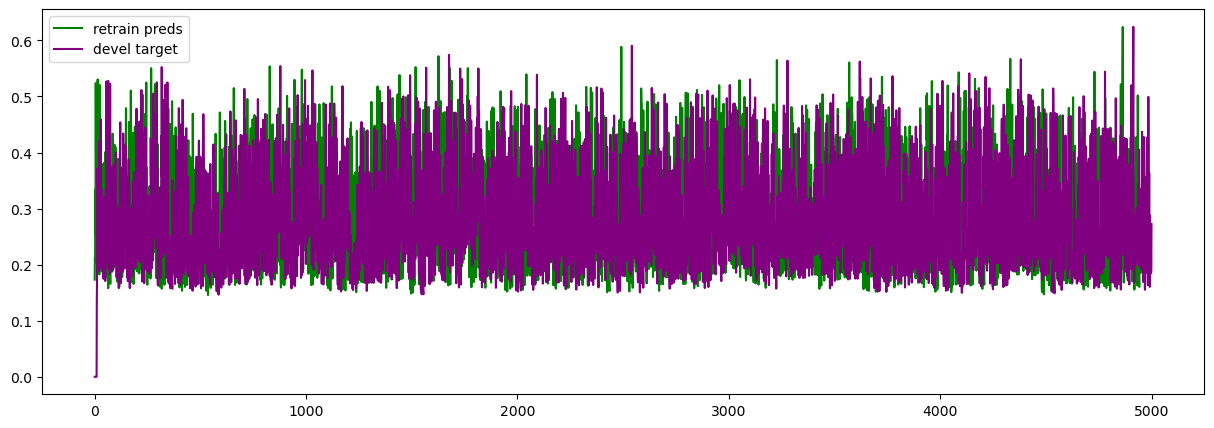

In [75]:
plt.plot(retrain_preds, label='retrain preds', color='green')
plt.plot(devel_target, label='devel target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()


Show test predictions of the first 1000 elems.

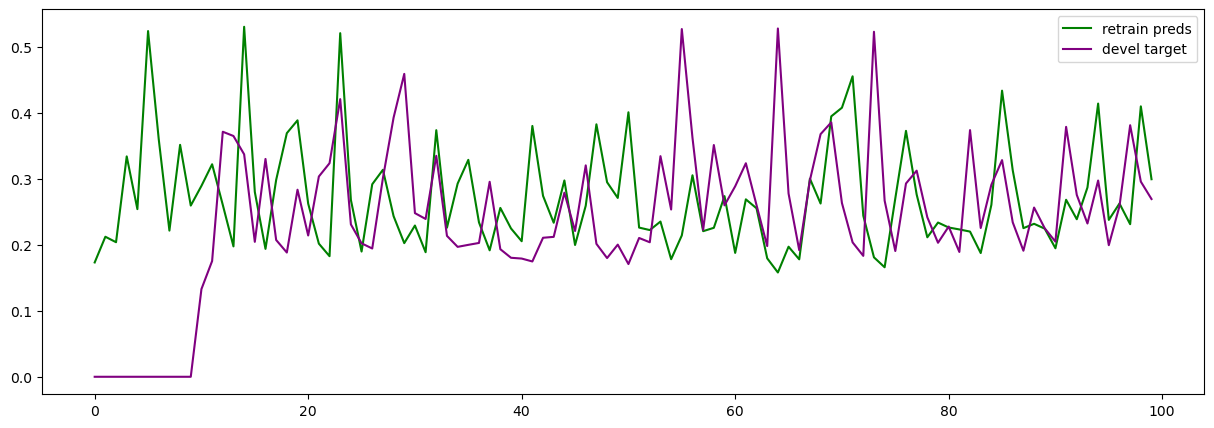

In [76]:
plt.plot(retrain_preds[:100], label='retrain preds', color='green')
plt.plot(devel_target[:100], label='devel target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()

Plot predicted and true values of the series for the test set.

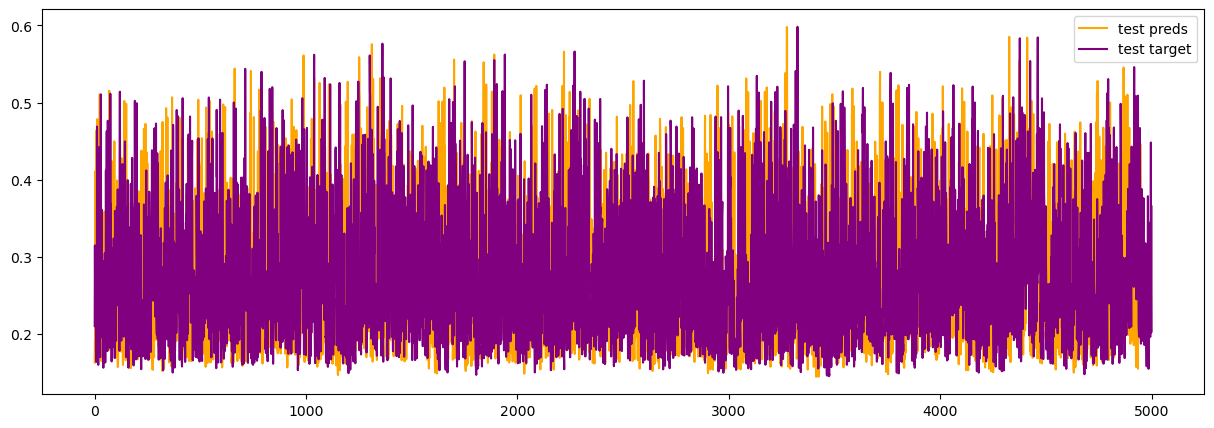

In [77]:
plt.plot(test_preds, label='test preds', color='orange')
plt.plot(test_target, label='test target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()

Show test predictions vs targets of the first 100 elems.

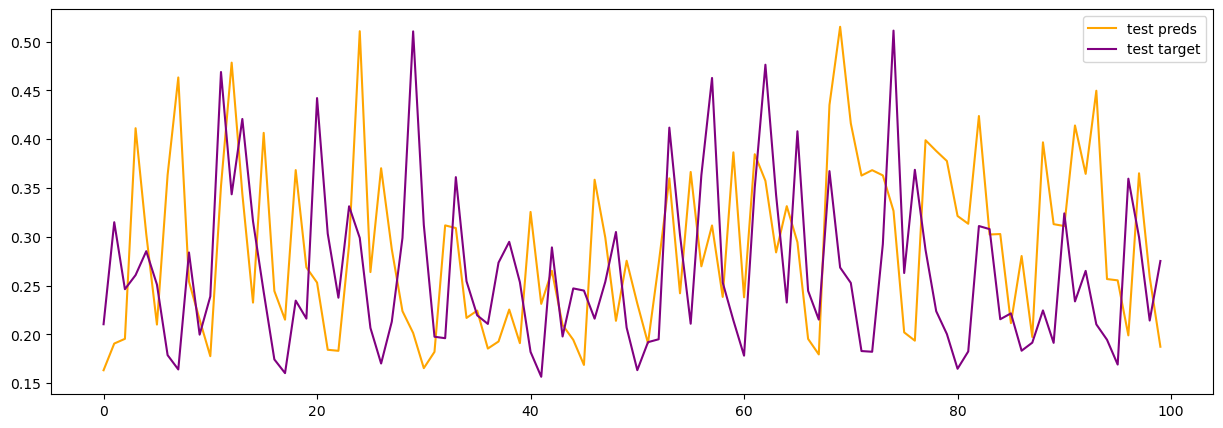

In [78]:
plt.plot(test_preds[:100], label='test preds', color='orange')
plt.plot(test_target[:100], label='test target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()